## TOPIC: Delayed getting medical care due to cost among adults
## SUBGROUPS Tried: "18-34 years", "50-64 years", "65 years and older

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv("./preprocessed_data.csv")
data

,TOPIC,GROUP,SUBGROUP,TIME_PERIOD,ESTIMATE,FLAG
0,Angina/angina pectoris,Total,18 years and older,2019,1.7,NaN
1,Angina/angina pectoris,Total,18 years and older,2020,1.5,NaN
2,Angina/angina pectoris,Total,18 years and older,2021,1.5,NaN
3,Angina/angina pectoris,Total,18 years and older,2022,1.6,NaN
4,Angina/angina pectoris,Total,18 years and older,2023,1.6,NaN
...,...,...,...,...,...,...
23604,Wellness visit,Poverty level,≥200% FPL,2020,78.9,NaN
23605,Wellness visit,Poverty level,≥200% FPL,2021,77.0,NaN
23606,Wellness visit,Poverty level,≥200% FPL,2022,78.8,NaN
23607,Wellness visit,Poverty level,≥200% FPL,2023,80.5,NaN


In [3]:
data["TOPIC"].value_counts()

TOPIC
Urgent care center or retail health clinic visit among adults:                   538
Prescription medication use among adults                                         464
Doctor visit among adults                                                        463
Wellness visit                                                                   463
Obesity in adults, self-reported                                                 462
Receipt of influenza vaccination among adults                                    462
Hypertension diagnosis, self-reported                                            462
Ever received a pneumococcal vaccination                                         462
Hospital emergency department visit                                              461
Arthritis diagnosis                                                              459
Regularly had feelings of worry, nervousness, or anxiety                         459
Has a usual place of care among adults                     

### Filtering only the three topics

In [4]:
selected_topics_data = data[data["TOPIC"].isin(["Delayed getting medical care due to cost among adults",
    "Did not get needed medical care due to cost",
    "Did not get needed mental health care due to cost"
])]

In [5]:
selected_topics_data["TOPIC"].value_counts()

TOPIC
Delayed getting medical care due to cost among adults    454
Did not get needed medical care due to cost              453
Did not get needed mental health care due to cost        445
Name: count, dtype: int64

# Trying SUBGROUP '18-34 years' first from TOPIC 'Delayed getting medical care due to cost among adults'

dtype('int64')

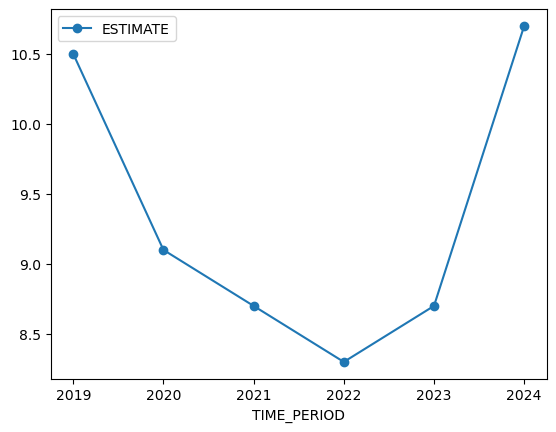

In [6]:
df_filtered = selected_topics_data[
    (selected_topics_data['TOPIC'] == 'Delayed getting medical care due to cost among adults') & 
    (selected_topics_data['SUBGROUP'] == "18-34 years")
][['TIME_PERIOD', 'ESTIMATE']]
df_filtered.plot(x='TIME_PERIOD', y='ESTIMATE', marker='o')
df_filtered['TIME_PERIOD'].dtype

## A. Model Selection
###  1. Fit a simple Linear model: ESTIMATE = a + b * (TIME_PERIOD)

In [7]:
from sklearn.linear_model import LinearRegression

df_filtered["t"] = df_filtered["TIME_PERIOD"] - df_filtered["TIME_PERIOD"].min()

X = df_filtered[['t']]
y = df_filtered['ESTIMATE']

model = LinearRegression()
model.fit(X,y)

next_year = df_filtered['TIME_PERIOD'].max()+1
first_year = df_filtered['TIME_PERIOD'].min()
t_next = next_year - first_year

print(model.predict(pd.DataFrame({'t': [t_next]}))[0])
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_)

r2_linear = model.score(df_filtered[["t"]], df_filtered["ESTIMATE"])

9.273333333333333
Intercept: 9.376190476190477
Coefficient: [-0.01714286]


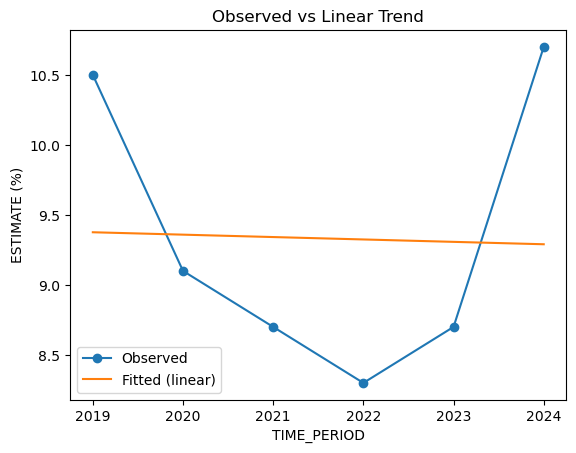

In [8]:
import matplotlib.pyplot as plt

df_filtered["fitted"] = model.predict(X)

ax = df_filtered.plot(x="TIME_PERIOD", y="ESTIMATE", marker="o", label="Observed")
df_filtered.plot(x="TIME_PERIOD", y="fitted", ax=ax, label="Fitted (linear)")

plt.title("Observed vs Linear Trend")
plt.ylabel("ESTIMATE (%)")
plt.show()

### 2. Piecewise Linear:

In [9]:
#post_2022 = 1     if TIME_PERIOD >= 2022    ==>  y^*(t)=α+β1*t+β2*t = α+(β1+β2)t
#            0     else 0                    ==>  y^(t)=α+β1*t

df = df_filtered.copy()

# break at 2022
df["post_2022"] = (df["TIME_PERIOD"] >= 2022).astype(int)
df["t"] = df["TIME_PERIOD"] - df["TIME_PERIOD"].min()
df["t_post"] = df["t"] * df["post_2022"]

X = df[["t", "t_post"]]
y = df["ESTIMATE"]

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients [pre-slope, slope-change]:", model.coef_)

r2_peicewise = model.score(df[["t", "t_post"]], df["ESTIMATE"])


Intercept: 9.796969696969699
Coefficients [pre-slope, slope-change]: [-0.57818182  0.49090909]


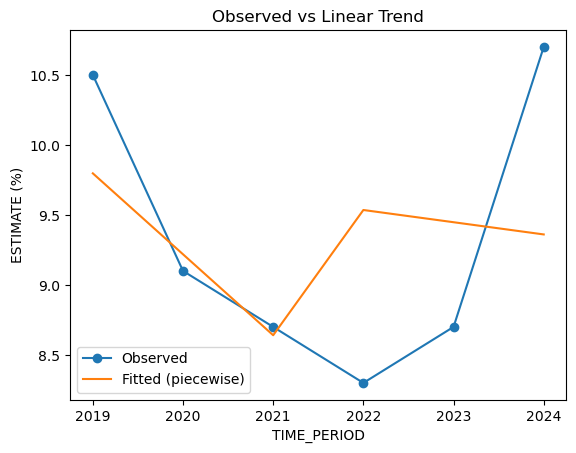

In [10]:
df = df_filtered.copy()
df["fitted"] = model.predict(X)

ax = df.plot(x="TIME_PERIOD", y="ESTIMATE", marker="o", label="Observed")
df.plot(x="TIME_PERIOD", y="fitted", ax=ax, label="Fitted (piecewise)")

plt.title("Observed vs Linear Trend")
plt.ylabel("ESTIMATE (%)")
plt.show()

### 3. Quadratic Model: ESTIMATE = a + b * (TIME_PERIOD) + b * (TIME_PERIOD)^2

In [11]:
df_filtered["t"] = df_filtered["TIME_PERIOD"] - df_filtered["TIME_PERIOD"].min()
df_filtered["t2"] = df_filtered["t"] ** 2

X = df_filtered[['t', 't2']]
y = df_filtered['ESTIMATE']

model = LinearRegression()
model.fit(X,y)

next_year = df_filtered['TIME_PERIOD'].max()+1
first_year = df_filtered['TIME_PERIOD'].min()
t_next = next_year - first_year

print(model.predict(pd.DataFrame({'t': [t_next], 't2': [t_next**2]})))

print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_)

r2_quad = model.score(df_filtered[["t", "t2"]], df_filtered["ESTIMATE"])


[12.64]
Intercept: 10.57857142857143
Coefficient: [-1.82071429  0.36071429]


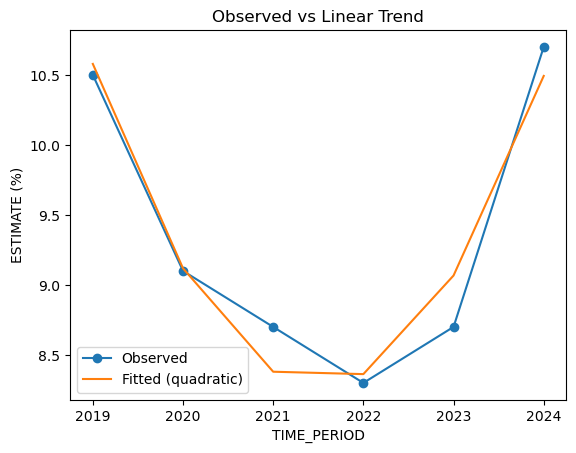

In [12]:
df = df_filtered.copy()
df["fitted"] = model.predict(X)

ax = df.plot(x="TIME_PERIOD", y="ESTIMATE", marker="o", label="Observed")
df.plot(x="TIME_PERIOD", y="fitted", ax=ax, label="Fitted (quadratic)")

plt.title("Observed vs Linear Trend")
plt.ylabel("ESTIMATE (%)")
plt.show()

### At what year is the estimate the lowest (the bottom of the U-shape)?

In [13]:
t_min = -model.coef_[0] / (2 * model.coef_[1])
year_min = df["TIME_PERIOD"].min() + t_min
print(year_min)

2021.5237623762375


## B. Model Comparison: Linear vs Piecewise vs  Quadratic Time Trend

In [23]:
print("R² linear:", r2_linear)
print("R² Piecewise:", r2_peicewise)
print("R² quadratic:", r2_quad)
print("Quadratic model clearly outperforms linear and piecewise models, capturing the dominant nonlinear temporal pattern.")

R² linear: 0.4823920265780731
R² Piecewise: 0.14797130424556015
R² quadratic: 0.8146179401993356
Quadratic model clearly outperforms linear and piecewise models, capturing the dominant nonlinear temporal pattern.


# Comparing SUBGROUPS: "18-34 years", "50-64 years", "65 years and older for the same TOPIC

Rows after filtering: 18
Subgroups matched: ['18-34 years' '50-64 years' '65 years and older']


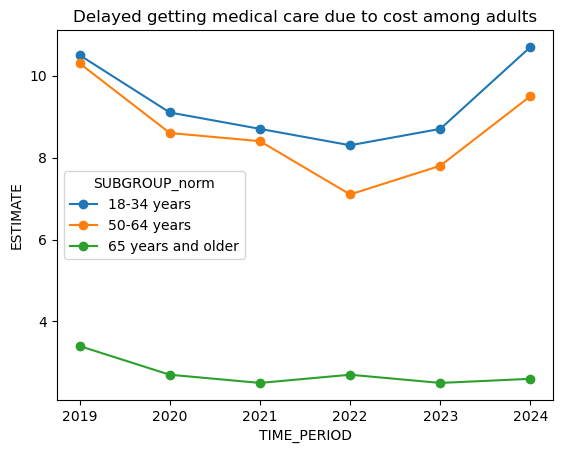

In [15]:
import matplotlib.pyplot as plt

topic = "Delayed getting medical care due to cost among adults"
subs = ["18-34 years", "50-64 years", "65 years and older"]  # use hyphen here

df = selected_topics_data.copy()

# normalize dashes + whitespace so matching works
df["SUBGROUP_norm"] = (df["SUBGROUP"].astype(str)
                       .str.replace("–", "-", regex=False)
                       .str.strip())
df["TOPIC_norm"] = df["TOPIC"].astype(str).str.strip()

df = df[(df["TOPIC_norm"] == topic) & (df["SUBGROUP_norm"].isin(subs))]

print("Rows after filtering:", len(df))
print("Subgroups matched:", df["SUBGROUP_norm"].unique())

df["TIME_PERIOD"] = pd.to_numeric(df["TIME_PERIOD"], errors="coerce")
pivot = (df.pivot_table(index="TIME_PERIOD", columns="SUBGROUP_norm", values="ESTIMATE", aggfunc="mean")
           .sort_index())

ax = pivot.plot(marker="o")
ax.set_title(topic)
ax.set_xlabel("TIME_PERIOD")
ax.set_ylabel("ESTIMATE")
plt.show()


## Finding appropriate model for each SUBGROUPS
topic = "Delayed getting medical care due to cost among adults" 


subgroups = ["18-34 years", "50-64 years", "65 years and older"]


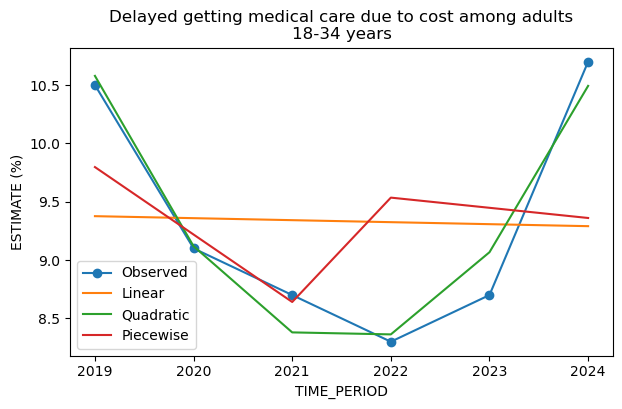

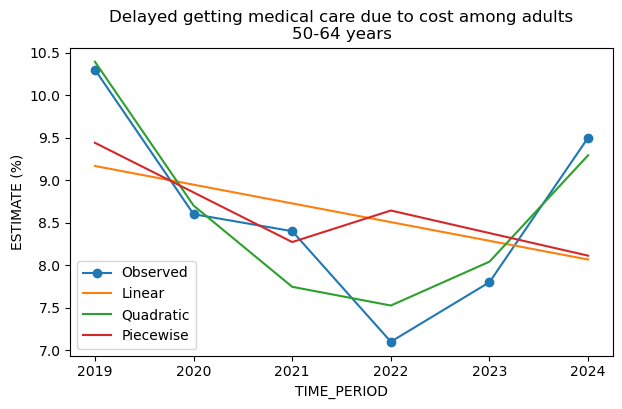

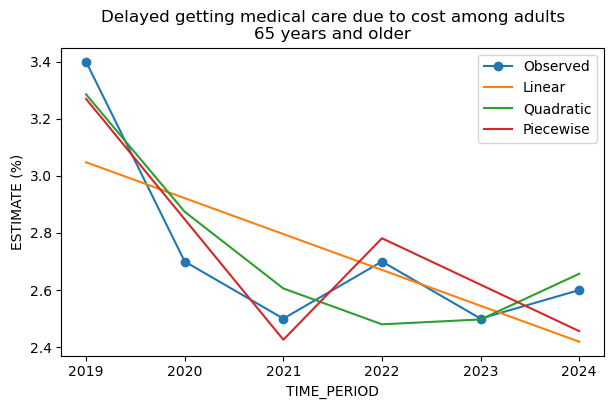

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

topic = "Delayed getting medical care due to cost among adults"
subgroups = ["18-34 years", "50-64 years", "65 years and older"]

results = []

for subgroup in subgroups:
    df = selected_topics_data[
        (selected_topics_data["TOPIC"] == topic) &
        (selected_topics_data["SUBGROUP"] == subgroup)
    ][["TIME_PERIOD", "ESTIMATE"]].copy()

    df = df.sort_values("TIME_PERIOD")
    df["t"] = df["TIME_PERIOD"] - df["TIME_PERIOD"].min()
    df["t2"] = df["t"] ** 2

    y = df["ESTIMATE"]

    ##
    next_year = 2025
    t_next = next_year - df['TIME_PERIOD'].min()

    # -------- Linear --------
    model_lin = LinearRegression()
    model_lin.fit(df[["t"]], y)
    df["fit_linear"] = model_lin.predict(df[["t"]])
    r2_linear = model_lin.score(df[["t"]], y)
    mse_lin = mean_squared_error(y, df["fit_linear"])
    mae_lin = mean_squared_error(y, df["fit_linear"])
    y_pred_lin = model_lin.predict(pd.DataFrame({'t': [t_next]}))
    
    # -------- Quadratic --------
    model_quad = LinearRegression()
    model_quad.fit(df[["t", "t2"]], y)
    df["fit_quad"] = model_quad.predict(df[["t", "t2"]])
    r2_quad = model_quad.score(df[["t", "t2"]], y)
    mse_quad = mean_squared_error(y, df["fit_quad"])
    mae_quad = mean_squared_error(y, df["fit_quad"])
    y_pred_quad = model_quad.predict(pd.DataFrame({'t': [t_next], 't2':[t_next**2]}))

    # -------- Piecewise --------
    df["post_2022"] = (df["TIME_PERIOD"] >= 2022).astype(int)
    df["t_post"] = df["t"] * df["post_2022"]

    model_pw = LinearRegression()
    model_pw.fit(df[["t", "t_post"]], y)
    df["fit_pw"] = model_pw.predict(df[["t", "t_post"]])
    r2_pw = model_pw.score(df[["t", "t_post"]], y)
    mse_pw = mean_squared_error(y, df["fit_pw"])
    mae_pw = mean_squared_error(y, df["fit_pw"])
    y_pred_pw = model_pw.predict(pd.DataFrame({"t": [t_next], "t_post": [t_next]})) # 2025 >= 2022, t_post = t_next*1

    # -------- Save R² --------
    results.append({
        "Subgroup": subgroup,
        "R2_linear": r2_linear,
        "R2_piecewise": r2_pw,
        "R2_quadratic": r2_quad,
        "mse_lin":mse_lin,
         "mse_piecewise": mse_pw,
         "mse_quadratic":mse_quad,
         "mae_lin":mae_lin,
         "mae_piecewise": mae_pw,
         "mae_quadratic":mae_quad,
        "y_pred_lin":y_pred_lin,
         "y_pred_piecewise": y_pred_pw,
         "y_pred_quadratic":y_pred_quad
    })

    plt.figure(figsize=(7, 4))
    plt.plot(df["TIME_PERIOD"], y, marker="o", label="Observed")
    plt.plot(df["TIME_PERIOD"], df["fit_linear"], label="Linear")
    plt.plot(df["TIME_PERIOD"], df["fit_quad"], label="Quadratic")
    plt.plot(df["TIME_PERIOD"], df["fit_pw"], label="Piecewise")
    
    plt.title(f"{topic}\n{subgroup}")
    plt.xlabel("TIME_PERIOD")
    plt.ylabel("ESTIMATE (%)")
    plt.legend()
    plt.show()


In [17]:
results

[{'Subgroup': '18-34 years',
  'R2_linear': 0.0009979671040476479,
  'R2_piecewise': 0.14797130424556015,
  'R2_quadratic': 0.9436148586213271,
  'mse_lin': 0.8580317460317454,
  'mse_piecewise': 0.7317979797979798,
  'mse_quadratic': 0.04842857142857129,
  'mae_lin': 0.8580317460317454,
  'mae_piecewise': 0.7317979797979798,
  'mae_quadratic': 0.04842857142857129,
  'y_pred_lin': array([9.27333333]),
  'y_pred_piecewise': array([9.27333333]),
  'y_pred_quadratic': array([12.64])},
 {'Subgroup': '50-64 years',
  'R2_linear': 0.12778476238370606,
  'R2_piecewise': 0.17578805403799125,
  'R2_quadratic': 0.8899529437120588,
  'mse_lin': 0.9635555555555565,
  'mse_piecewise': 0.910525252525253,
  'mse_quadratic': 0.12157142857142839,
  'mae_lin': 0.9635555555555565,
  'mae_piecewise': 0.910525252525253,
  'mae_quadratic': 0.12157142857142839,
  'y_pred_lin': array([7.84666667]),
  'y_pred_piecewise': array([7.84666667]),
  'y_pred_quadratic': array([11.28])},
 {'Subgroup': '65 years and ol

In [18]:
print("Age 18–34: Error(MAE & MSE) decreases from Linear to Piecewise to Quadratic models.")
print("Age 50–64: Error(MAE & MSE) decreases from Linear to Piecewise to Quadratic models.")
print("Age 65+: Piecewise model yields the lowest error(MAE & MSE), followed by Quadratic and Linear.")

Age 18–34: Error(MAE & MSE) decreases from Linear to Piecewise to Quadratic models.
Age 50–64: Error(MAE & MSE) decreases from Linear to Piecewise to Quadratic models.
Age 65+: Piecewise model yields the lowest error(MAE & MSE), followed by Quadratic and Linear.
